# Online Contextual Bandits
** *
This IPython notebook illustrates the usage of the [contextualbandits](https://www.github.com/david-cortes/contextualbandits) package's `online` module through a simulation with public datasets.

**Small note: if the TOC here is not clickable or the math symbols don't show properly, try visualizing this same notebook from nbviewer following [this link](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb).**

** *
### Sections 

[1. Problem description](#p1)

[2. Algorithms](#p2)

[3. Experiments](#p3)

* [3.1 Reading the data](#p31)

* [3.2 Full-batch models](#p32)

* [3.3 Streaming models](#p33)

[4. References](#p4)

** *
<a id="p1"></a>
## 1. Problem description

Contextual bandits, also known as multi-armed bandits with covariates or associative reinforcement learning, is a problem similar to multi-armed bandits, but with the difference that side information or covariates are available at each iteration and can be used to select an arm, whose rewards are also dependent on the covariates.
 

The problem comes from an iterative process generating data as follows:

* At each round, the world creates an observation consisting of a set of covariates $X$ of fixed dimension and a vector of rewards $r$ (which are stochastic but dependent on the covariates) of length corresponding to $m$, the number of arms.

* An agent must choose an arm or label for the observation among the set of $m$ arms.

* The world reveals the reward for the arm chosen by the agent, but not for the other arms.

The purpose is of course to build a policy that would maximize the rewards obtained by the agent. The arms might also expire over time and new arms might appear too, leading to the same exploration-exploitation dilemma faced in multi-armed bandits.

The problem is very similar to multi-class or multi-label classification (with the reward being whether the right label was chosen or not), but with the big difference that the right label or set of labels is not known for each observation, only whether the label that was chosen by the agent for each observation was correct or not.

Examples of such scenarios include online advertising, where we only know whether a user clicked an ad that he was presented with, but don't know which other ads he would have clicked; or clinic trials where we know how a person responded to a treatment, but don't know how he would have responded to a different treatment.

While, in general, algorithms for the contextual bandits problem assume continuous rewards in the range $r \in [0,1]$, **this package deals only with the case of discrete rewards $r \in \{0,1\}$.**
 

This IPython notebook in particular deals with the problem of building online algorithms that would work with little or no data, and which have to make a trade-off between exploring new or little-known arms or exploiting what's known to be good arms.

For the related problems of policy evaluation (determining how good is an algorithm given that we don't know the right labels for each observation) and off-policy learning (constructing better algorithms from data consisting of actions chosen by a different policy) see the other IPython notebooks [Off-policy Learning in Contextual Bandits](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/offpolicy_learning.ipynb) and [Policy Evaluation in Contextual Bandits](http://nbviewer.jupyter.org/github/david-cortes/contextualbandits/blob/master/example/policy_evaluation.ipynb).

** *
<a id="p2"></a>
## 2. Algorithms 

 

The same high-level ideas from multi-armed bandits can be adapted to work with contextual bandits too, taking a binary classifier algorithm as a base or "oracle". These include:

* Upper-confidence bounds (a.k.a. "Optimism in the face of uncertainty"), consisting in taking an upper bound on the reward predicted for an arm. From this family, the package includes the algorithms `BootstrappedUCB`, `LogisticUCB`, and `LinUCB`.

* Thompson sampling, consisting in choosing an arm with probability proportional to it being the best arm. The implementations in this package include `BootstrappedTS`, `LogisticTS`, `LinTS`, and `SoftmaxExplorer`. Note that the `LogisticTS`, `LinTS` are not scalable to high-dimensional data, and thus not shown here.

* Greedy exploration, consisting in choosing an arm at random sometimes so as to keep exploring. The implementation here is `EpsilonGreedy`. Other approaches such as epoch-greedy, while seemingly good in theory, don't seem to be competitive or perform well in practice, so I preferred to skip them.

* Adaptive exploration, consisting in choosing an arm according to models when we expect a reward with high certainty, and choosing another at random when not. The implementation here is `AdaptiveGreedy`.

* Explore-then-exploit, consisting in choosing arms at random until sufficient data is gathered, and then exploiting based on the information available.

Additionally, the package includes the heuristic `ActiveExplorer` based on "active learning", which tries to choose an observation according to its leverage on the model if its label were known; and `SeparateClassifiers`, which fits separate models for each arm with no guiding heuristic.

For more information see the documentation of each policy (e.g. you can try `help(contextualbandits.online.BootstrappedUCB`) and the references section at the end.

All of these heuristics are enhanced with an optional beta prior for arms for which not enough information to build a classifier is available, which will make predictions as random numbers drawn from a beta distribution with a pre-specified prior. In a cold-start scenario, the priors chosen a make a huge impact on the short- and middle-term performance of policies, even bigger than the heuristic chosen, so be careful to tune it properly.

 

All the policies/heuristics shown here, except for `LogisticUCB` and `LinUCB`, are meta-heuristics that take a binary classifier algorithm as a base in order to choose arms. Note that, while they are meant for an online learning scenario, in this first section they are refit with all the data each time rather than progrssively adding batches of data with a `partial_fit` method (see the end of the notebook for an incremental-fitting version).

The classifier to pass to them must have a scikit-learn-like API (not necessarily fully scikit-learn-compatible) with `fit` and `predict_proba`/`decision_function`/`predict` methods.

Links to the documentationof the online module: [https://contextual-bandits.readthedocs.io](https://contextual-bandits.readthedocs.io)

** *
<a id="p3"></a>
## 3. Experiments 

 

Data for contextual bandits is not easily available, and it's hard to work with in terms of evaluation, but it is possible to turn any multi-label classification dataset into contextual bandits by revealing only the class for one label per observation. Doing this also has the advantage that we know also the rewards for all other arms when we want to evaluate a policy, but we can choose not to reveal them to the agent to simulate a real scenario. 
 

The experiments here consist in iterating over a multi-label dataset, letting each policy make choices as it passes through the data and observes rewards for the actions it chooses, and recording the reward that they receive – that is, whether the labels they choose were correct or not. The base classification algorithm used is logistic regression from scikit-learn's `linear_model`.


The data used is the [Bibtex dataset](http://mlkd.csd.auth.gr/publication_details.asp?publicationID=278) see (_"Multilabel text classification for automated tag suggestion"_), containing tags that people have assigned to different papers (the goal being to learn to suggest tags based on features from the papers), which is publicly available under the [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html).


**As a shorthand, the module `contextualbandits.evaluation` also contains a function [evaluateFullyLabeled](http://contextual-bandits.readthedocs.io/en/latest/index.html#contextualbandits.evaluation.evaluateFullyLabeled) that automates all the predict-evaluate-refit process done here in one function.**

<a id="p31"></a>
** *
### 3.1 Reading the data

Loading the data - format is a sparse text file as used in libsvm and others, but with the first line indicating the number of rows, columns, and classes:

In [1]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("Bibtex_data.txt")
print(X.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


<a id="p32"></a>
** *
## 3.2 Full-batch models

Turning logistic regression into contextual bandits policies:

In [2]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
### Important!!! the default values for beta_prior will be changed in version 0.2.8

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = 1111)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior = beta_prior, random_state = 2222)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                  beta_prior = beta_prior, random_state = 3333)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                               beta_prior = beta_prior, random_state = 4444)
logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                           beta_prior = beta_prior_ucb, random_state = 5555)
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                     decay_type='threshold',
                                     beta_prior = beta_prior, random_state = 6666)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                      decay_type='percentile', decay=0.9997,
                                       beta_prior=beta_prior, random_state = 7777)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                             explore_rounds=1500, beta_prior=None, random_state = 8888)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                 beta_prior=beta_prior, random_state = 9999)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                        active_choice='weighted', decay_type='percentile', decay=0.9997,
                                        beta_prior=beta_prior, random_state = 1234)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior=beta_prior, random_state = 5678)

models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, logistic_ucb,
          adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer,
          adaptive_active_greedy, softmax_explorer]

Now running the experiment:

In [3]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_lucb, \
rewards_agr, rewards_agr2, rewards_efr, rewards_ac, \
rewards_aac, rewards_sft = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_lucb,
               rewards_agr, rewards_agr2, rewards_efr, rewards_ac,
               rewards_aac, rewards_sft]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_lucb, lst_a_agr, \
lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, \
lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_lucb, lst_a_agr,
               lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist],
              warm_start = True)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X, y,
                                             batch_st, batch_end)

Visualizing results:

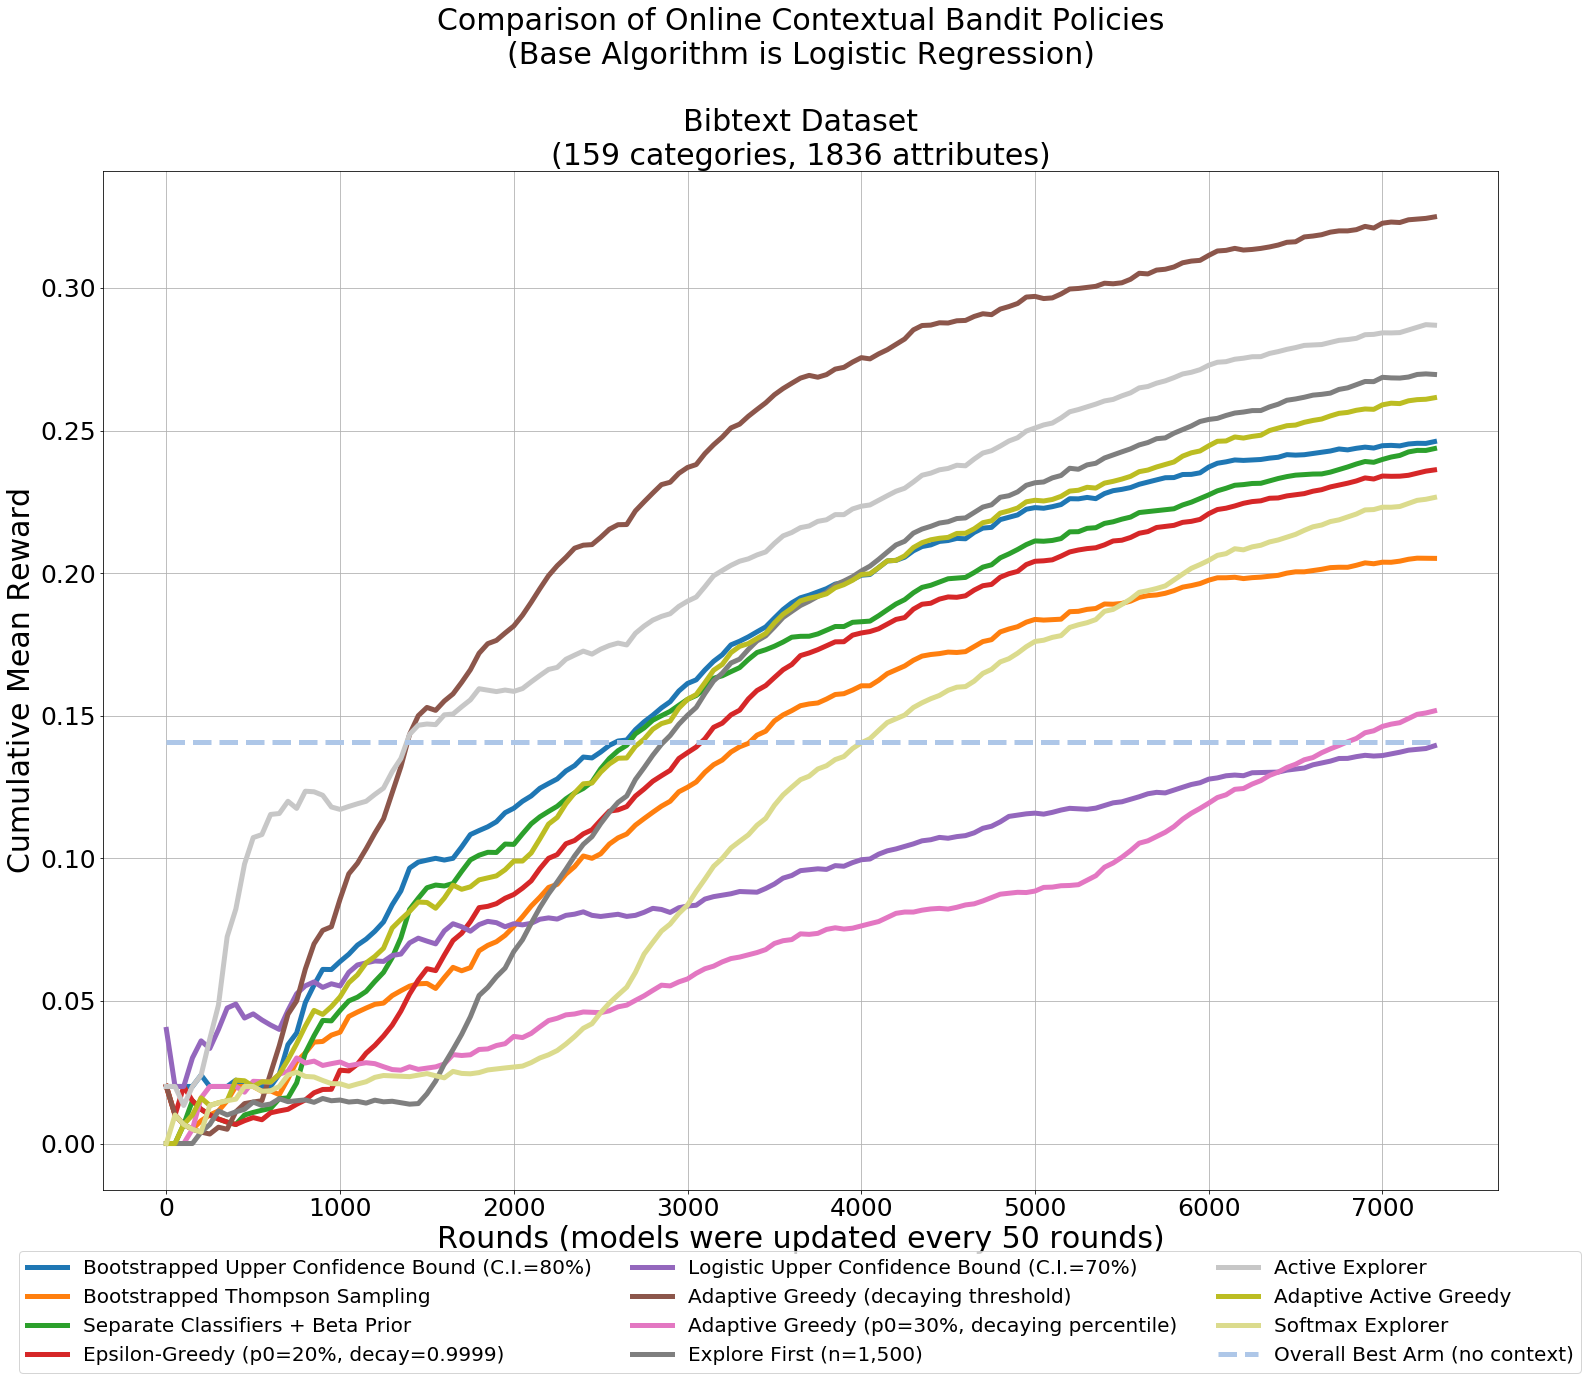

In [4]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_lucb), label="Logistic Upper Confidence Bound (C.I.=70%)",linewidth=lwd,color=colors[8])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

In [5]:
### Try to free memory for the next example
del models
del bootstrapped_ucb
del bootstrapped_ts
del one_vs_rest
del epsilon_greedy
del logistic_ucb
del adaptive_greedy_thr
del adaptive_greedy_perc
del explore_first
del active_explorer
del adaptive_active_greedy
del softmax_explorer

import gc
gc.collect()

1460

<a id="p33"></a>
** *
### 3.3 Streaming models

Same data and metaheuristics as before, but this time fitting the data in small batches, without letting the algorithms have access to all their historical data - this time the algorithms are scikit-learn's `SGDClassifier` and this module's `LinearRegression`, as these metaheuristics assume a `partial_fit` method.

Note1: unlike `SGDClassifier` this module's `LinearRegression` is not stochastic, but rather, keeps the matrices from the closed-form solution and updates them incrementally.

Note2: these methods used with streaming data are a lot more sensitive to hyperparameters such as `beta_prior` or `smoothing` and to differences in random seeds. Be sure to tune the hyperparameters well.

**Note3:** This package assumes that it is passed binary classifiers as base algorithm, but here sometimes it is passed a regressor, which is technically incorrect, but still gives reasonable results. As well, the `smoothing` transformation becomes incorrect when the predictions are unbounded, but performance-wise it doesn't matter too much.

**Important:** These streaming-data examples use a lot of RAM memory. This is due to `LinearRegression` and `LinUCB` keeping track of the matrices they calculate for each arm, which scales quadratically with the number of features. Due to memory constraints, not all methods are shown here. This section uses around 7.5GB of RAM (vs. around 1.8GB from the previous example).

In [6]:
from sklearn.linear_model import SGDClassifier
from contextualbandits.linreg import LinearRegression
from contextualbandits.online import LinUCB, AdaptiveGreedy, \
        SoftmaxExplorer, ActiveExplorer, EpsilonGreedy

nchoices = y.shape[1]
base_sgd = SGDClassifier(random_state=123, loss='log', warm_start=False)
base_ols = LinearRegression(lambda_=10., fit_intercept=True, method="sm")

## Metaheuristic using different base algorithms and configurations
linucb = LinUCB(nchoices = nchoices, beta_prior = None, alpha = 0.1,
                ucb_from_empty = False, random_state = 1111)
### Important!!! the default hyperparameters for LinUCB in the reference paper
### are very different from what's used in this example
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                        smoothing = None, beta_prior = ((3./nchoices,4.), 2),
                                        active_choice = 'weighted', decay_type = 'percentile',
                                        decay = 0.9997, batch_train = True,
                                        random_state = 2222)
softmax_explorer = SoftmaxExplorer(deepcopy(base_sgd), nchoices = nchoices,
                                   smoothing = (1,2), beta_prior = None, batch_train = True,
                                   refit_buffer = 50, deep_copy_buffer = False, random_state = 3333)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_ols), nchoices = nchoices,
                                      smoothing = (1,2), beta_prior = None,
                                      decay_type = 'percentile', decay = 0.9997, batch_train = True,
                                      random_state = 4444)
active_explorer = ActiveExplorer(deepcopy(base_sgd), smoothing = None, nchoices = nchoices,
                                 beta_prior = ((3./nchoices, 4.), 2), batch_train = True, refit_buffer = 50,
                                 deep_copy_buffer = False, random_state = 5555)
epsilon_greedy_nodecay = EpsilonGreedy(deepcopy(base_ols), nchoices = nchoices,
                                       smoothing = (1,2), beta_prior = None,
                                       decay = None, batch_train = True,
                                       deep_copy_buffer = False, random_state = 6666)


models = [linucb, adaptive_active_greedy, softmax_explorer, adaptive_greedy_perc,
          active_explorer, epsilon_greedy_nodecay]

Now running the experiment:

In [7]:
# These lists will keep track of the rewards obtained by each policy
rewards_lucb, rewards_aac, rewards_sft, rewards_agr, \
rewards_ac, rewards_egr = [list() for i in range(len(models))]

lst_rewards = [rewards_lucb, rewards_aac, rewards_sft,
               rewards_agr, rewards_ac, rewards_egr]

# batch size - algorithms will be refit after N rounds
batch_size=50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X[:batch_size, :]
action_chosen = np.random.randint(nchoices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

# fitting models for the first time
for model in models:
    np.random.seed(123)
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_lucb, lst_a_aac, lst_a_sft, lst_a_agr, \
lst_a_ac, lst_a_egr = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_lucb, lst_a_aac, lst_a_sft,
               lst_a_agr, lst_a_ac, lst_a_egr]

# rounds are simulated from the full dataset
def simulate_rounds_stoch(model, rewards, actions_hist, X_batch, y_batch, rnd_seed):
    np.random.seed(rnd_seed)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_batch).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_batch[np.arange(y_batch.shape[0]), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # rewards obtained now
    rewards_batch = y_batch[np.arange(y_batch.shape[0]), actions_this_batch]
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(rnd_seed)
    model.partial_fit(X_batch, actions_this_batch, rewards_batch)
    
    return new_actions_hist

# now running all the simulation
for i in range(int(np.floor(X.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])
    
    X_batch = X[batch_st:batch_end, :]
    y_batch = y[batch_st:batch_end, :]
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds_stoch(models[model],
                                                   lst_rewards[model],
                                                   lst_actions[model],
                                                   X_batch, y_batch,
                                                   rnd_seed = batch_st)

Visualizing results:

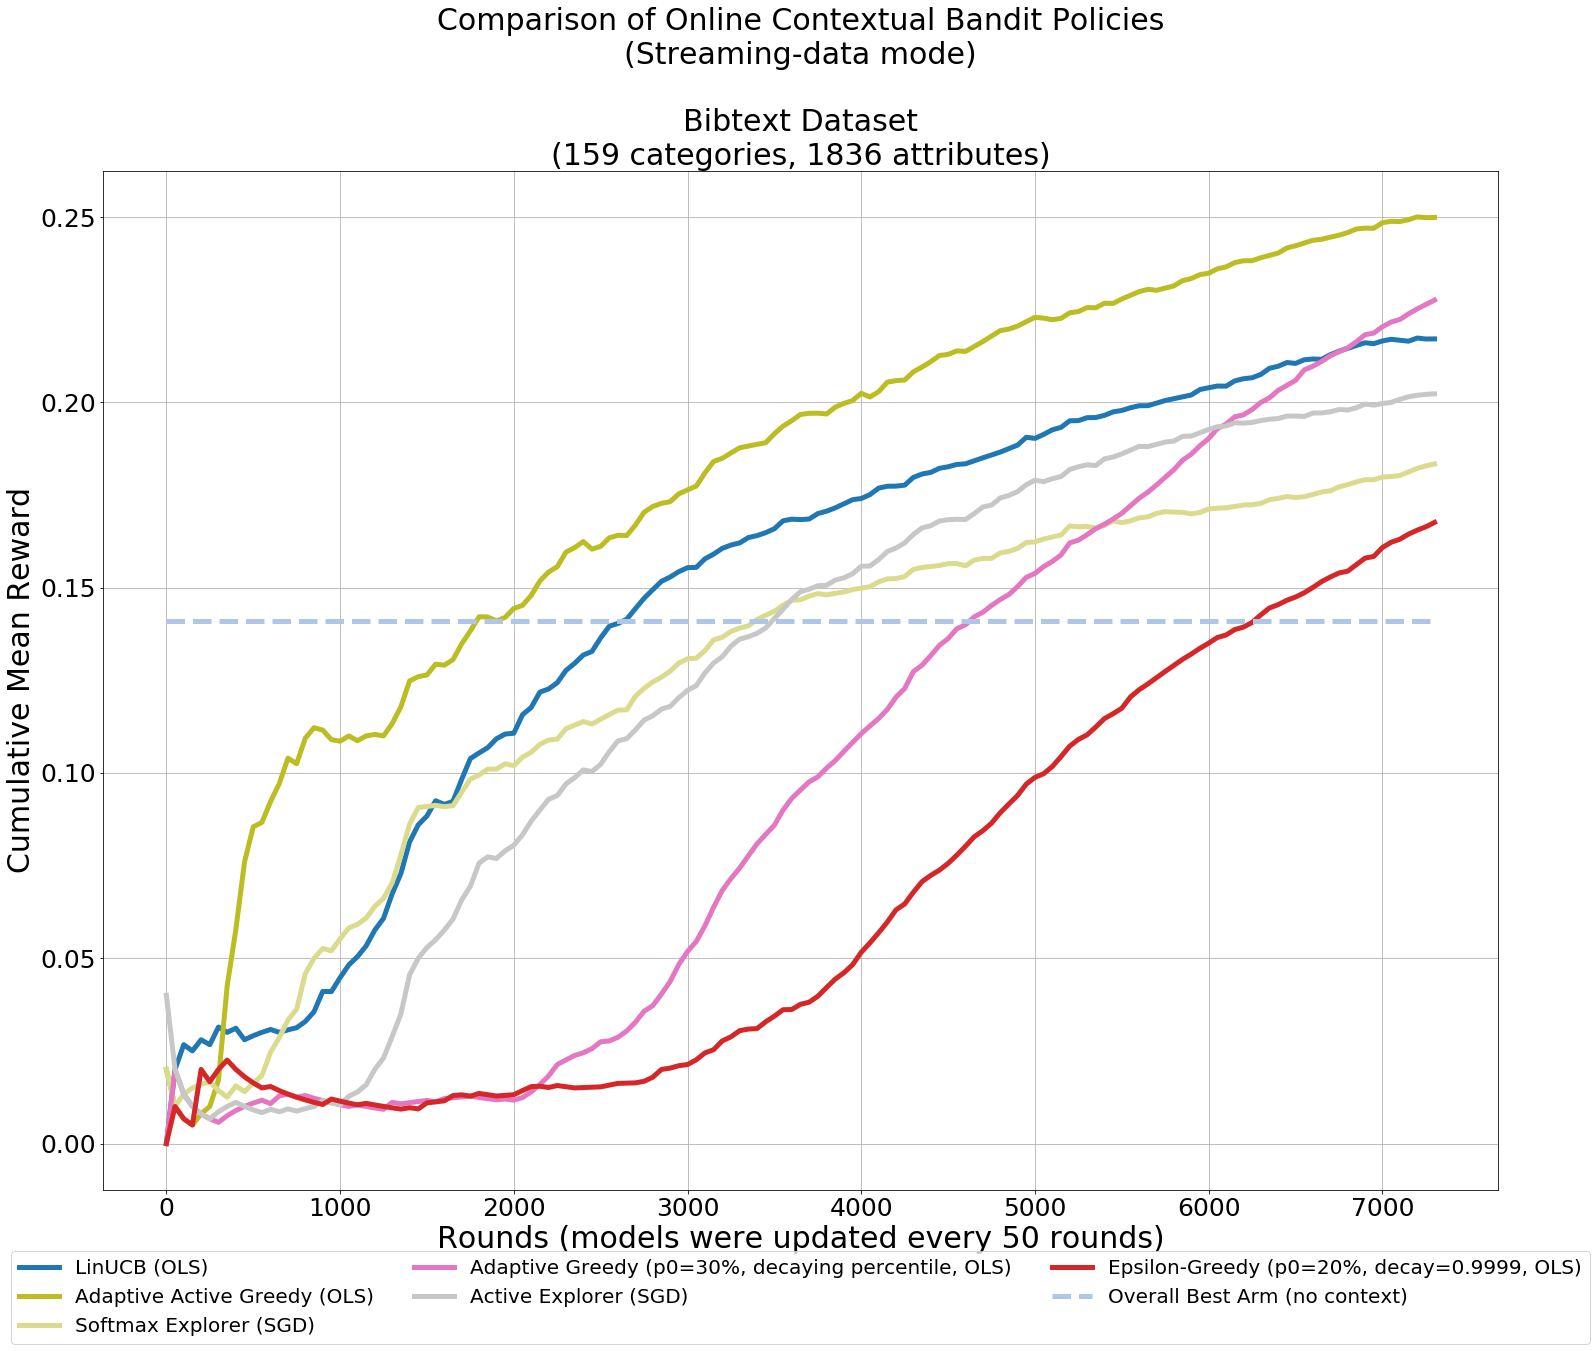

In [8]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 25, 15

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_lucb), label="LinUCB (OLS)", linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy (OLS)", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer (SGD)", linewidth=lwd,color=colors[17])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (p0=30%, decaying percentile, OLS)", linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer (SGD)", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999, OLS)",linewidth=lwd,color=colors[6])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])


plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Streaming-data mode)\n\nBibtext Dataset\n(159 categories, 1836 attributes)',size=30)
plt.grid()
plt.show()

<a id="p4"></a>
## 4. References
* Cortes, David. "Adapting multi-armed bandits policies to contextual bandits scenarios." arXiv preprint arXiv:1811.04383 (2018).

* Katakis, I., Tsoumakas, G., & Vlahavas, I. (2008, September). Multilabel text classification for automated tag suggestion. In Proceedings of the ECML/PKDD (Vol. 18).

* Snoek, C. G., Worring, M., Van Gemert, J. C., Geusebroek, J. M., & Smeulders, A. W. (2006, October). The challenge problem for automated detection of 101 semantic concepts in multimedia. In Proceedings of the 14th ACM international conference on Multimedia (pp. 421-430). ACM.

* Chapelle, O., & Li, L. (2011). An empirical evaluation of thompson sampling. In Advances in neural information processing systems (pp. 2249-2257).

* Agrawal, S., & Goyal, N. (2013, February). Thompson sampling for contextual bandits with linear payoffs. In International Conference on Machine Learning (pp. 127-135).

* Li, L., Chu, W., Langford, J., & Schapire, R. E. (2010, April). A contextual-bandit approach to personalized news article recommendation. In Proceedings of the 19th international conference on World wide web (pp. 661-670). ACM.

* Chakrabarti, D., Kumar, R., Radlinski, F., & Upfal, E. (2009). Mortal multi-armed bandits. In Advances in neural information processing systems (pp. 273-280).

* Vermorel, J., & Mohri, M. (2005, October). Multi-armed bandit algorithms and empirical evaluation. In European conference on machine learning (pp. 437-448). Springer, Berlin, Heidelberg.